# Add Dependencies

In [18]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
!pip install -Uqq fastai
!pip install nbdev
!pip install duckduckgo-search
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 60.1 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 24.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.6/813.6 kB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 18

In [19]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from fastai.vision.widgets import *
import gradio as gr

# Gathering Data

In [14]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

urls = search_images('grizzly bear', max_images=150)
urls[0]

Searching for 'grizzly bear'


'http://2.bp.blogspot.com/-NjMTuklENdE/UHzVv_8dIxI/AAAAAAAAA-U/tNBsQDn8kFI/s1600/Grizzly+Bear+Pic.jpg'

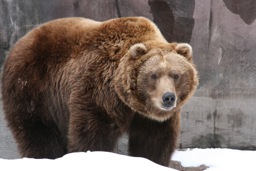

In [11]:
dest = 'images/grizzly.jpg'
download_url(urls[0], dest, show_progress=False)


im = Image.open(dest)
im.to_thumb(256,256)

In [7]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        urls = search_images(f'{o} bear')
        download_images(dest, urls=urls)

In [15]:
fns = get_image_files(path)
fns

(#88) [Path('bears/grizzly/9b407f30-6f7c-4fc5-a20f-b84f703871d2.jpg'),Path('bears/grizzly/483cd18f-0aed-4fb8-ad18-1b0695451bd5.jpg'),Path('bears/grizzly/45ef632c-18f5-476b-9da7-a4a77b0fbf1d.jpg'),Path('bears/grizzly/4bbb0db5-dfe6-4811-ae31-cd06ea847550.jpg'),Path('bears/grizzly/1f244786-1411-4cca-b110-d91d7e0b953f.jpg'),Path('bears/grizzly/295da4de-756b-4864-bf1f-efdfadb21c87.jpg'),Path('bears/grizzly/0d40a7ce-b5e5-4c3a-8835-4397d5f0535a.jpg'),Path('bears/grizzly/252104ee-60ca-4ee1-82c5-d62e5b660d0b.jpg'),Path('bears/grizzly/eec30cb0-dc5b-4186-a93e-1612e134521a.jpg'),Path('bears/grizzly/235f2a43-a514-4182-b21b-262340ef8baa.jpg')...]

In [16]:
failed = verify_images(fns)
failed

(#2) [Path('bears/black/337df6d0-0be1-4ac9-a454-4c7a7973ac82.jpg'),Path('bears/teddy/fc73697d-6189-42d2-8310-4860783e1782.jpg')]

In [17]:
failed.map(Path.unlink);

In [18]:
??verify_images

Signature: verify_images(fns)
Source:   
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)
File:      /usr/local/lib/python3.9/dist-packages/fastai/vision/utils.py
Type:      function


# From Data to DataLoaders

DataLoaders is a thin class that just stores whatever DataLoader objects you pass to it, and makes them available as train and valid. Although it's a very simple class, it's very important in fastai: it provides the data for your model. The key functionality in DataLoaders is provided with just these four lines of code (it has some other minor functionality we'll skip over for now):


```
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])
```

To turn our downloaded data into a DataLoaders object we need to tell fastai at least four things:

1. What kinds of data we are working with
2. How to get the list of items
3. How to label these items
4. How to create the validation set

So far we have seen a number of factory methods for particular combinations of these things, which are convenient when you have an application and data structure that happen to fit into those predefined methods. For when you don't, fastai has an extremely flexible system called the data block API. With this API you can fully customize every stage of the creation of your DataLoaders. Here is what we need to create a DataLoaders for the dataset that we just downloaded:

In [7]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

We provide a tuple where we specify what types we want for the independent and dependent variables:

`blocks=(ImageBlock, CategoryBlock)`

The independent variable is the thing we are using to make predictions from, and the dependent variable is our target. In this case, our independent variables are images, and our dependent variables are the categories (type of bear) for each image.

For this DataLoaders our underlying items will be file paths. We have to tell fastai how to get a list of those files. The `get_image_files` function takes a path, and returns a list of all of the images in that path (recursively, by default).


`parent_label` is a function provided by fastai that simply gets the name of the folder a file is in. Because we put each of our bear images into folders based on the type of bear, this is going to give us the labels that we need.


This has given us a `DataBlock` object. This is like a template for creating a `DataLoaders`. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:


In [10]:
dls = bears.dataloaders(path)

A DataLoaders includes validation and training DataLoaders. DataLoader is a class that provides batches of a few items at a time to the GPU. When you loop through a DataLoader fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a DataLoader:

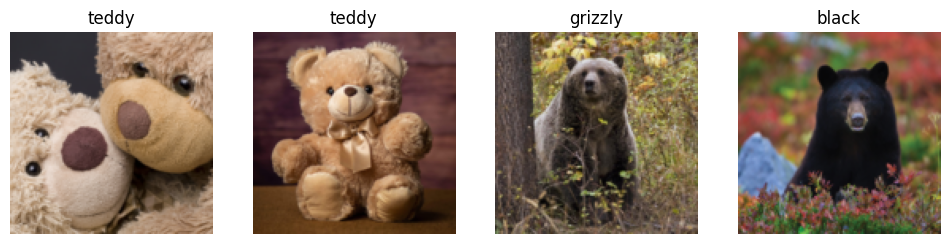

In [11]:
dls.valid.show_batch(max_n=4, nrows=1)

You can ask fastai to pad the images with zeros (black), or squish/stretch them:

```
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)
```

```
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)
```

All of these approaches seem somewhat wasteful, or problematic. If we squish or stretch the images they end up as unrealistic shapes, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. 

Here's another example where we replace `Resize` with `RandomResizedCrop`, which is the transform that provides the behavior we just described. The most important parameter to pass in is `min_scale`, which determines how much of the image to select at minimum each time:
We used unique=True to have the same image repeated with different versions of this RandomResizedCrop transform. This is a specific example of a more general technique, called data augmentation.

```
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)
```

Data augmentation refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the `aug_transforms` function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the `batch_tfms` parameter (note that we're not using RandomResizedCrop in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):


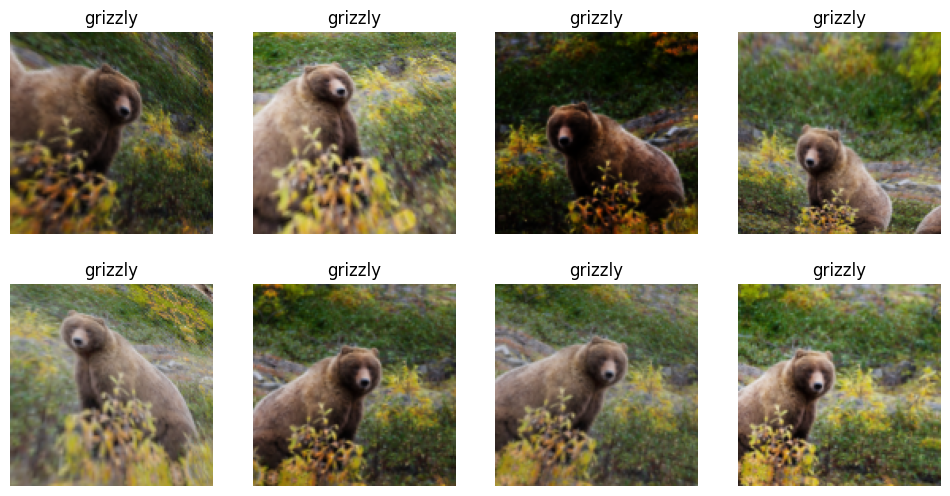

In [12]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Training Your Model, and Using It to Clean Your Data

We don't have a lot of data for our problem, so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and `default aug_transforms`:

In [13]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.891967,1.786217,0.529412,00:10


epoch,train_loss,valid_loss,error_rate,time
0,2.351267,1.321115,0.470588,00:08
1,1.627342,0.581984,0.294118,00:08
2,1.205126,0.314138,0.176471,00:08
3,0.958344,0.219780,0.058824,00:08



Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a confusion matrix:

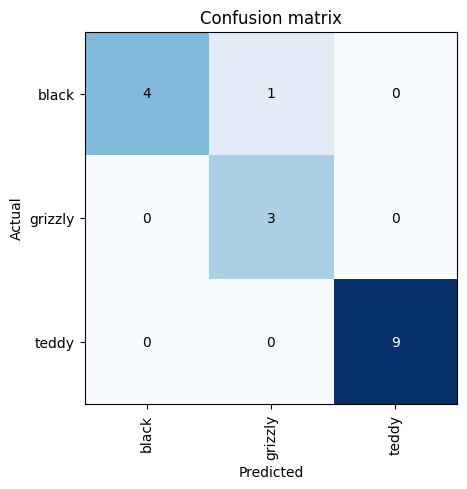

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The rows represent all the black, grizzly, and teddy bears in our dataset, respectively. The columns represent the images which the model predicted as black, grizzly, and teddy bears, respectively. Therefore, the diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly. This is one of the many ways that fastai allows you to view the results of your model. It is (of course!) calculated using the validation set. With the color-coding, the goal is to have white everywhere except the diagonal, where we want dark blue. Our bear classifier isn't making many mistakes!

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't bears at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their loss.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. Soon we'll learn in depth how loss is calculated and used in the training process. For now, `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The probability here is the confidence level, from zero to one, that the model has assigned to its prediction:

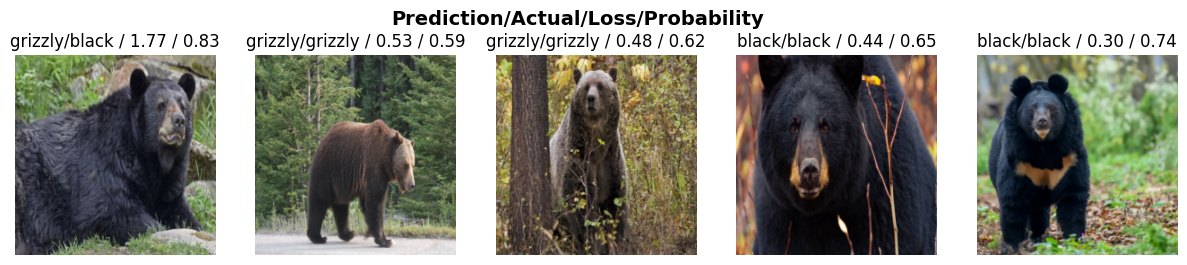

In [16]:
interp.plot_top_losses(5, nrows=1)

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

```
cleaner = ImageClassifierCleaner(learn)
cleaner
```

We can see that amongst our "black bears" is an image that contains two bears: one grizzly, one black. So, we should choose <Delete> in the menu under this image. `ImageClassifierCleaner` doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change. So, for instance, to delete (unlink) all images selected for deletion, we would run:

```
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
```
To move images for which we've selected a different category, we would run:

```
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```
Cleaning the data and getting it ready for your model are two of the biggest challenges for data scientists; they say it takes 90% of their time. The fastai library aims to provide tools that make it as easy as possible.

Note: No Need for Big Data: After cleaning the dataset using these steps, we generally are seeing 100% accuracy on this task. We even see that result when we download a lot fewer images than the 150 per class we're using here. As you can see, the common complaint that you need massive amounts of data to do deep learning can be a very long way from the truth!


# Turning Your Model into an Online Application

Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the architecture and the trained parameters. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the export method.

This method even saves the definition of how to create your `DataLoaders`. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set `DataLoader` for inference by default, so your data augmentation will not be applied, which is generally what you want.

In [22]:
learn.export()

Let's check that the file exists, by using the ls method that fastai adds to Python's Path class:

In [9]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

When we use a model for getting predictions, instead of training, we call it inference. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):



In [10]:
learn_inf = load_learner(path/'export.pkl')

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to predict:

In [26]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([1.4525e-04, 9.9789e-01, 1.9626e-03]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the vocab of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:



In [11]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

# Gradio + HuggingFace Spaces

[Gradio + HuggingFace Spaces: A Tutorial On See Tanishq Abraham's Blog](https://www.tanishq.ai/blog/gradio_hf_spaces_tutorial)

## Train A Pet Classifier

In [16]:
path = untar_data(URLs.PETS)
dls = ImageDataLoaders.from_name_re(
    path, get_image_files(path/'images'), pat='(.+)_\d+.jpg', 
    item_tfms=Resize(460), batch_tfms=aug_transforms(size=224, min_scale=0.75))
learn = vision_learner(dls, models.resnet50, metrics=accuracy)
learn.fine_tune(1)
learn.path = Path('.')
learn.export('pets.pkl')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.947339,0.292298,0.907307,00:47


epoch,train_loss,valid_loss,accuracy,time
0,0.435811,0.242504,0.924899,01:02


## Using Gradio

In [ ]:
learn = load_learner('pets.pkl')

labels = learn.dls.vocab

def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

gr.Interface(fn=predict,
             inputs=gr.inputs.Image(shape=(512, 512)),outputs=gr.outputs.Label(num_top_classes=3),
             title=title,description=description,article=article,examples=examples,
             interpretation=interpretation,enable_queue=enable_queue).launch(share=True)


## Exporting A Python Script From Jupyter Notebook

1. At the top most cell add `#|default_exp python_script_name.py`
2. Add `#|export` on top of each cell you want to export to the python script
3. At the very bottom, when all required cells are ready, export them using:

```
from nbdev.export import notebook2script
notebook2script(fast_ai_deployment.ipynb)

```

## Using HuggingFace Spaces

1. Create a Space by clicking "New Space" on the navigation menu
2. Now you will be shown instructions on how to add your code to this Space from the command line to prepare the demo. Spaces are essentially git repositories (like GitHub) with an app.py file from which the demo is prepared.
3. Clone the repository and add the files (app.py, requirements.txt, pets.pkl, puppy.jpg)
4. Before comitting, reduce the size of pets.pkl using:
    - brew install git-lfs
    - git lfs install
    - git lfs track "*.pkl"
    - git add .gitattributes
    - git commit -m "update .gitattributes so git lfs will track .pkl files"
5. git commit -am "let's deploy to huggingface spaces" && git push

After a few moments, during which the app is being built, our demo should show up on the HuggingFace Space.
